## Nanocintas de grafeno con borde zig-zag y vacantes

In [2]:
from math import pi, sqrt, tanh
from matplotlib import pyplot #plotting
import kwant
import numpy as np

# defino la red
graphene = kwant.lattice.honeycomb()
a, b = graphene.sublattices

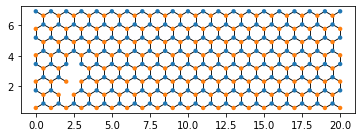

In [3]:
# inicio el sistema
syst = kwant.Builder()

def make_system(l = 10, w = 10, pot = 0.1):
    def nrb(pos):
        (x,y) = pos
        return 0 <= x <= l and 0.5 <= y <=w
# onsite
    def potential(site):                        
        (x,y) = site.pos
        return pot    
    syst[graphene.shape(nrb, (0, 0))] = potential 
    
# hoppings
    hoppings = ()
    syst[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings]] = -1
    syst[graphene.neighbors()] = -1

# vacantes
    # de una en una
    del syst[a(1,2)]
    # por forma
    def in_hole(site):
        x, y = site.pos  
        return 2 < x < 3 and 2 < y < 4

    for site in filter(in_hole, list(syst.sites())):
        del syst[site]

# simetrías
    sym = kwant.TranslationalSymmetry((-1,0))       # tradicional (acepta vectores reales)
    sym.add_site_family(a, other_vectors= [(-1,2)]) # (*) append (acepta vectores de la red)
    sym.add_site_family(b, other_vectors= [(-1,2)]) # (*) append (acepta vectores de la red)
    
    # (*) añado una celda unidad fundamental específica para la t.sym
    # con other_vectors añado un vector que complementa la t.sym de arriba
    # los vectores que defino forman una base y pueden dar direcciones
    # que no se pueden conseguir con los  vectores primitivos

# leads
    lead = kwant.Builder(sym)
    def lead_shape(pos):
        (x,y) = pos
        return 0.5 <= y <= w
    
    lead[graphene.shape(lead_shape, (1,1))] = -pot
    lead[graphene.neighbors()] = -1
    return syst, [lead,lead.reversed()]


    
    
syst, leads = make_system(l= 20, w = 7, pot = 0.1)
kwant.plot(syst); 
    

In [4]:
def plot_conductance(syst, energies):
    # Transmisión como función de la energía
    data = []
    for energy in energies:
        smatrix = kwant.smatrix(syst, energy)    # computa la matriz de scattering (que es dispersa)
        data.append(smatrix.transmission(0, 1))  # añade la transmisión a la smatrix -> genera

    pyplot.figure()
    pyplot.plot(energies, data)
    pyplot.xlabel("energía [t]")
    pyplot.ylabel("conductancia [e^2/h]")
    pyplot.show()

# Estructura de bandas

def plot_bandstructure(flead, momenta):
# kwant.phy... devuelve un array de NumPy array que contiene los autobvalores de todos los
# modos para un momento
    bands = kwant.physics.Bands(flead)
    energies = [bands(k) for k in momenta]

    pyplot.figure()
    pyplot.plot(momenta, energies)
    pyplot.xlabel("momento [(constante de red)^-1]")
    pyplot.ylabel("energía [t]")
    pyplot.show()   

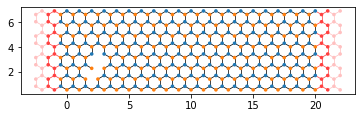

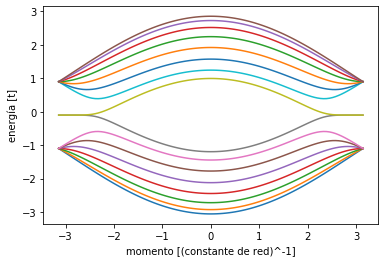

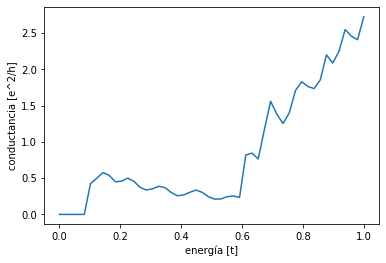

In [5]:
## Representaciones
# Terminamos el sistema y añadimos los leads, preparándolo para los cálculos
for lead in leads:
    syst.attach_lead(lead)
syst = syst.finalized()

# Dibujamos el sistema
kwant.plot(syst);
# Dibujamos la estructura de bandas de lead0 (izq)
momenta = [-pi + 0.02 * pi * i for i in range(101)]
plot_bandstructure(syst.leads[0], momenta);
# Dibujamos la conductancia
plot_conductance(syst, energies = np.linspace(0, 1))